# Ensemble Learning through Soft Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}

**soft voting**

$ \hat{y} = (\sum_{i = 0}^M \frac{\mu_i}{\sigma_i + \epsilon} )(\sum_i \sigma_i + \epsilon )$


In [59]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    ## colab
    import sys,os
    !git clone  https://github.com/tlpss/ML-Project2.git
    sys.path.append(os.path.abspath(os.path.join('./ML-Project2')))

In [60]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X
from aggregating.models import SoftBagger

## Parameter Configuration

In [61]:
np.random.seed(2020)

In [62]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [63]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [64]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) + WhiteKernel(noise_level= (lambda_range[0]+lambda_range[1]/2) , noise_level_bounds=lambda_range)


In [65]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [66]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.0793534441124991

In [67]:
X_test.shape

(50000, 1, 2)

## Compare with Hard voting

In [55]:
##

from aggregating.models import SoftBagger, SimpleBagger
from aggregating.utils import flatten_X
soft = SoftBagger(3,0.8,GaussianProcessRegressor(kernel,copy_X_train=False))
hard = SimpleBagger(3,0.8,GaussianProcessRegressor(kernel,copy_X_train=False))
soft.fit(flatten_X(X_train),y_train)
hard.fit(flatten_X(X_train),y_train)

#compare soft & hard prediction
from aggregating.utils import normalized_error_VT
print(normalized_error_VT(y_test, soft.predict(flatten_X(X_test)), V_0))
print(normalized_error_VT(y_test, hard.predict(flatten_X(X_test)), V_0))

In [56]:
#
#x  =  X_test[1023]
#for predictor in soft.predictors:
#    print(predictor.predict(x,return_std=True))
#print(soft.predictors[0].kernel)
#print(soft.predictors[1].kernel)

In [57]:
from sklearn.base import clone
gpr1  = GaussianProcessRegressor(kernel,copy_X_train=False)
gpr2  = clone(gpr1)
gpr1.fit(flatten_X(X_train[2:10]),y_train[2:10])
gpr2.fit(flatten_X(X_train[12:20]),y_train[12:20])

print(gpr1.predict(X_test[4],return_std = True))
print(gpr2.predict(X_test[4],return_std = True))

(array([0.]), array([0.07199992]))
(array([0.]), array([0.22160727]))


## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [68]:
#reference error: no ensemble

hyperparams= {'M':1, 'train_size_alpha':1.0}
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],5,N_test,MaxCallStochasticModel)
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 27000
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.11480572178179495
{'M': 1, 'train_size_alpha': 1.0} , 1 -> 0.17124000725126198
{'M': 1, 'train_size_alpha': 1.0} , 2 -> 0.14258894235284092
{'M': 1, 'train_size_alpha': 1.0} , 3 -> 0.12155161802293622
{'M': 1, 'train_size_alpha': 1.0} , 4 -> 0.14485188343340394
{'M': 1, 'train_size_alpha': 1.0} -> [0.11480572178179495, 0.17124000725126198, 0.14258894235284092, 0.12155161802293622, 0.14485188343340394]
0.1390076345684476


In [69]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading


# GRIDSEARCH PARAMS
model = SoftBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 3
M_grid = [1,3,5,7,9]
alpha_grid = [0.2,0.3,0.4,0.5]
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(cpu_count()-2) #hyperthreading 
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel,V_0,None,[2020,2021,2022]),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



 {'M': 1, 'train_size_alpha': 0.2} -> thread id = 27396
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.3} -> thread id = 32212
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.4} -> thread id = 35832
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.5} -> thread id = 11556
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.2} -> thread id = 32352
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.3} -> thread id = 33332
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.4} -> thread id = 30864
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.5} -> thread id = 32288
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.2} -> thread id = 6904
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.3} -> thread id = 9868
fit
(5000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.2} , 0 -> 0.17313162276083055
{'M': 1, 'train_

In [70]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[1, 0.2, [0.17313162276083055, 0.1649779892069589]]
[1, 0.3, [0.14230661457869873, 0.14649089164607434]]
[1, 0.4, [0.16531525899052069, 0.15545160203724143]]
[1, 0.5, [0.17596005733088052, 0.1994861258830614]]
[3, 0.2, [0.12578042671038817, 0.14600409284764]]
[3, 0.3, [0.11703114938599625, 0.14057159425957708]]
[3, 0.4, [0.1285065048999104, 0.13725879278456166]]
[5, 0.2, [0.10860763576483276, 0.11620155288838113]]
[3, 0.5, [0.16777019225513715, 0.17978123282173591]]
[5, 0.3, [0.1262048182977584, 0.12936135089604583]]
[5, 0.4, [0.11865641634802318, 0.1269894768192698]]
[7, 0.2, [0.110721454079486, 0.12143765967833374]]
[7, 0.3, [0.12176968274954814, 0.12959792890501706]]
[5, 0.5, [0.13353740105871378, 0.13810934577597228]]
[7, 0.4, [0.11633595123531777, 0.12487340501202425]]
[9, 0.2, [0.115245293902222, 0.12634085279094862]]
[9, 0.3, [0.11476289884716312, 0.13017912231674575]]
[7, 0.5, [0.13629341911944662, 0.14664752415429416]]
[9, 0.4, [0.12440045722083164, 0.140862411695777]]
[9, 0.5

In [71]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(5, 4)

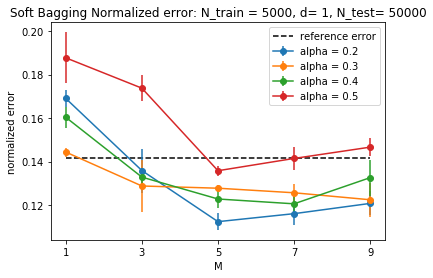

In [72]:
plt.hlines(0.1419,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Soft Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.savefig("soft_bagging.png")
plt.show()


## Store results

In [73]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [74]:
import json
import datetime
with open(f'soft_bagging_w_replacement_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)